# Vehicle Detection Project

**The goals / steps of this project are the following:**

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Training Images

Load Traing Images

In [1]:
import os
import glob
import time
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline


cars = []
notcars = []
cars.extend(glob.glob('data/cars1/*.jpeg'))
cars.extend(glob.glob('data/cars2/*.jpeg'))
cars.extend(glob.glob('data/cars3/*.jpeg'))
notcars.extend(glob.glob('data/notcars1/*.jpeg'))
notcars.extend(glob.glob('data/notcars2/*.jpeg'))
notcars.extend(glob.glob('data/notcars3/*.jpeg'))
print("read training images done")

read training images done


See Cars

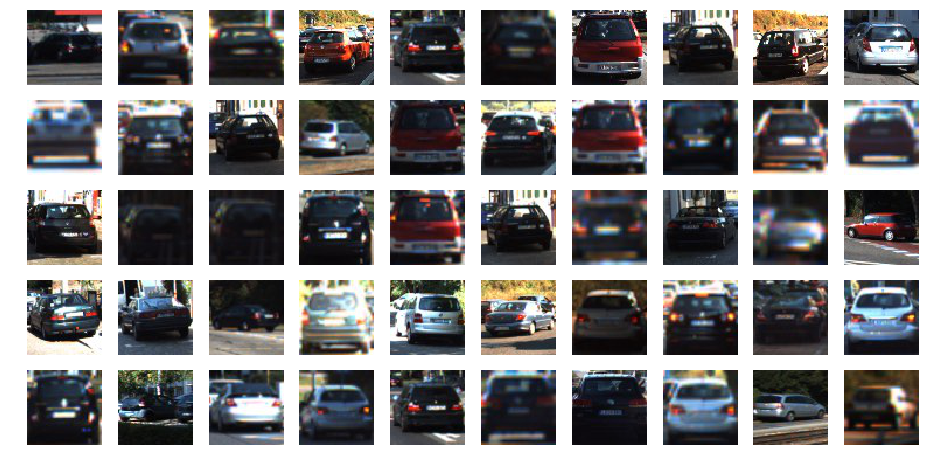

In [2]:
cars_index_randoms = []
cars_images = []
# show image of 15 random data points
fig, axs = plt.subplots(5,10, figsize=(16,8))
axs = axs.ravel()
for i in range(50):
    index = random.randint(0, len(cars))
    cars_index_randoms.append(index)
    image = mpimg.imread(cars[index])
    cars_images.append(image)
    axs[i].axis('off')
    axs[i].imshow(image)

See Not-cars

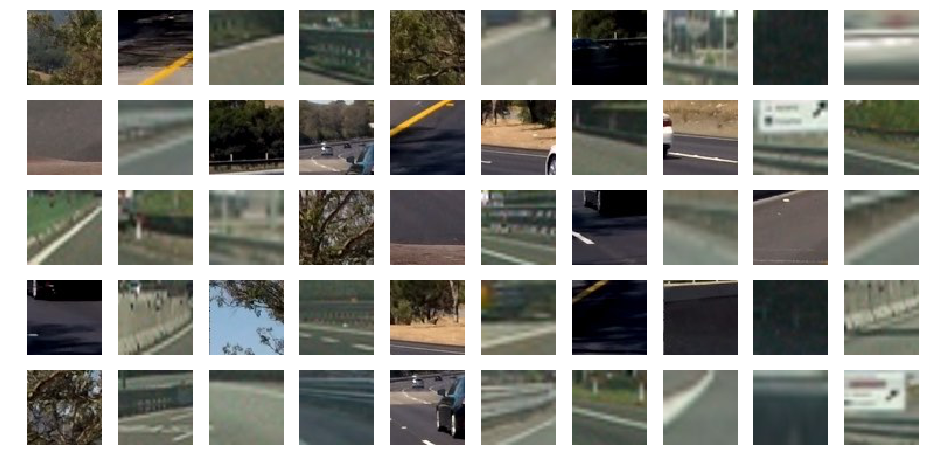

In [3]:
notcars_index_randoms = []
notcars_images = []
# show image of 15 random data points
fig, axs = plt.subplots(5,10, figsize=(16,8))
axs = axs.ravel()
for i in range(50):
    index = random.randint(0, len(notcars))
    notcars_index_randoms.append(index)
    image = mpimg.imread(notcars[index])
    notcars_images.append(image)
    axs[i].axis('off')
    axs[i].imshow(image)

# Histogram of Oriented Gradients (HOG)

### 1. Extracted color features from the training images.

Explain Histograms of Color

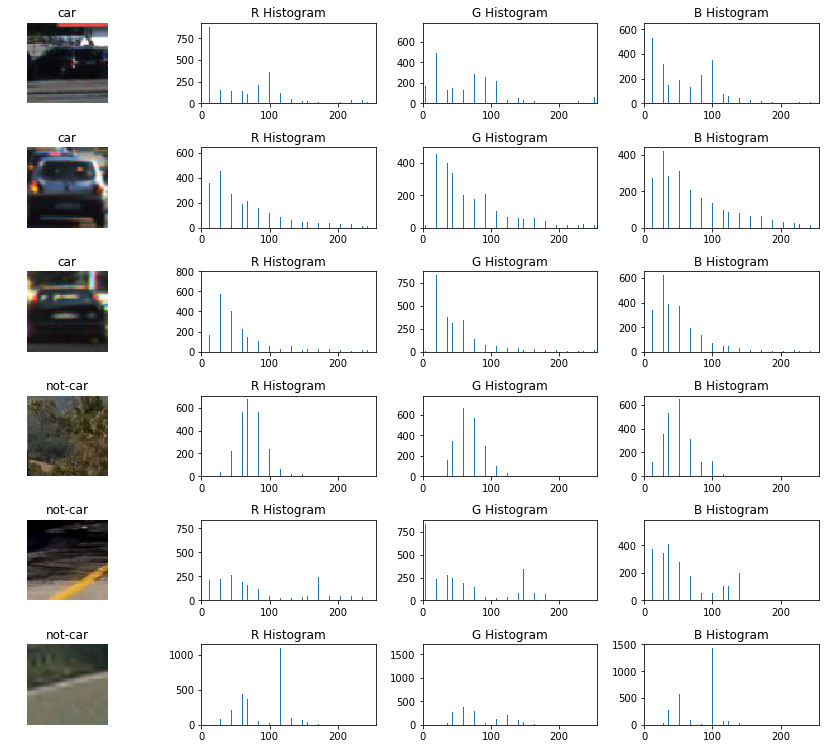

In [4]:
import numpy as np

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[:len(bin_edges) - 1] + bin_edges[1:]) / 2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

infos =[]
for i in range(3): infos.append((cars_images[i], "car"))
for i in range(3): infos.append((notcars_images[i], "not-car"))
num = len(infos)
fig = plt.figure(figsize=(12,2*num))
for i in range(num):
    image,label = infos[i]
    rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))
    # Plot a figure with all three bar charts
    plt.subplot(num+1,4,4*i+1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    plt.subplot(num+1,4,4*i+2)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(num+1,4,4*i+3)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(num+1,4,4*i+4)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
fig.tight_layout()

Explore Color Spaces

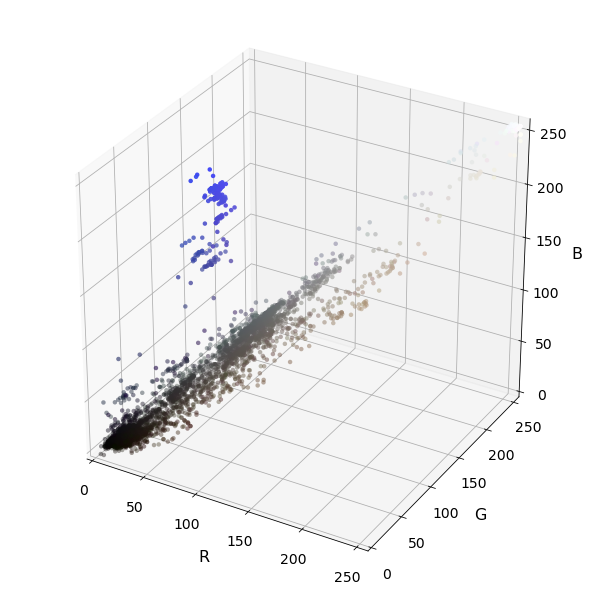

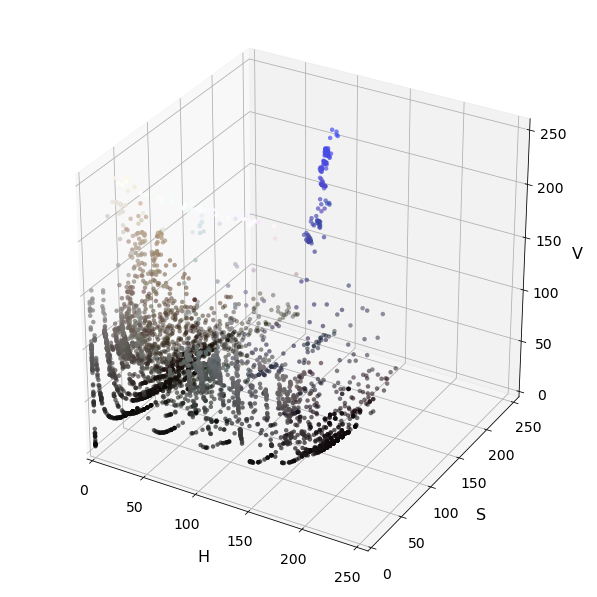

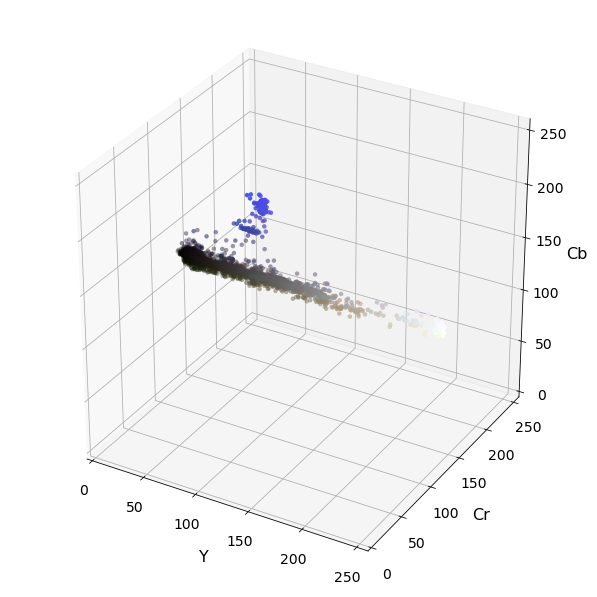

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Read a color image
img = cars_images[0]

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# # Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()
plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list(['Y','Cr','Cb']))
plt.show()

Spatial Binning of Color

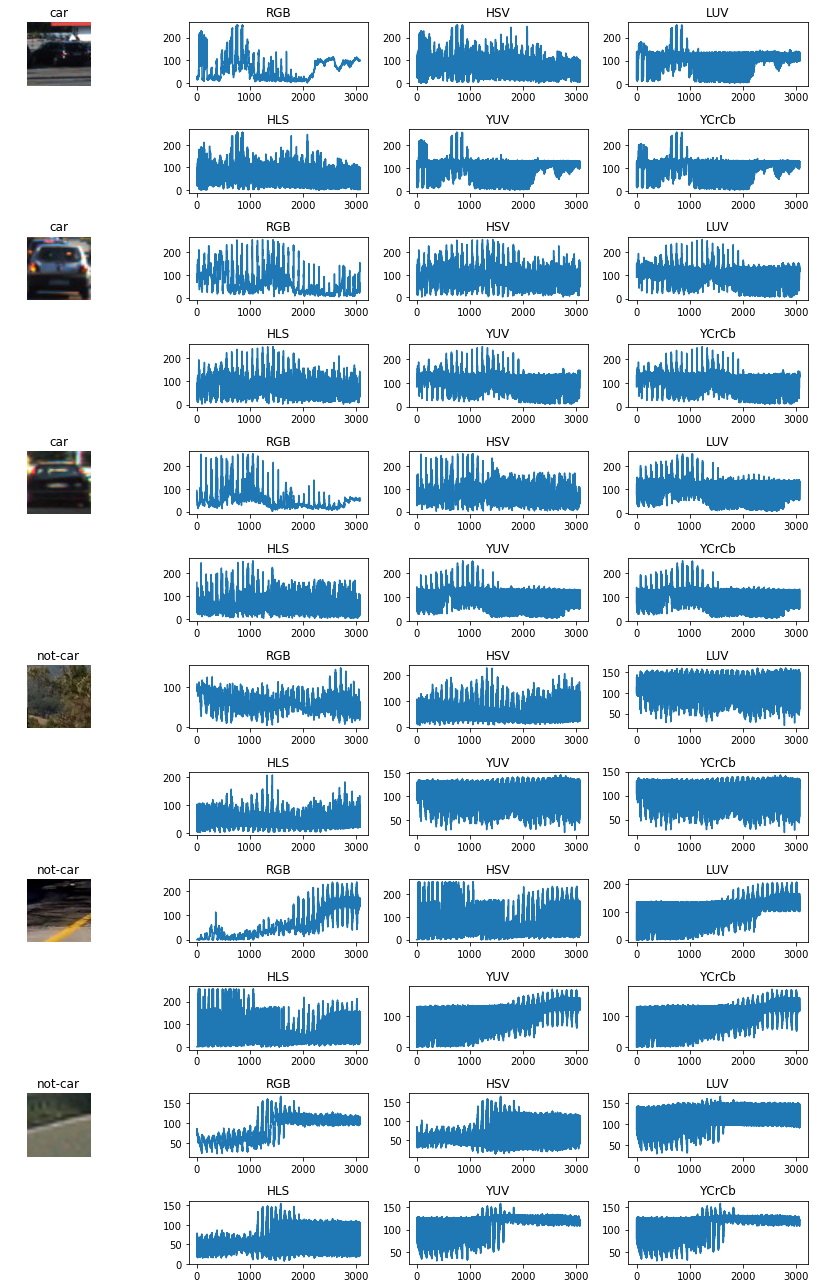

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

infos = []
for i in range(3): infos.append((cars_images[i], "car"))
for i in range(3): infos.append((notcars_images[i], "not-car"))
num = len(infos)
colors = ['RGB','HSV','LUV','HLS','YUV','YCrCb']
colors_num = len(colors)
fig = plt.figure(figsize=(12,3*num))
for i in range(num):
    image,label = infos[i]
    # Plot a figure with all three bar charts
    plt.subplot(num*2,4,8*i+1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    for j in range(colors_num):
        feature_vec = bin_spatial(image, color_space=colors[j], size=(32, 32))
        if j < 3: plt.subplot(num*2,4,8*i+2+j)
        else: plt.subplot(num*2,4,8*i+3+j)
        plt.plot(feature_vec)
        plt.title(colors[j])
fig.tight_layout()

i choose the color space YCrCb

### 2. Extracted HOG features from the training images.

Here is an example using HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2, 2)

C:\Users\elnin\Anaconda2\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


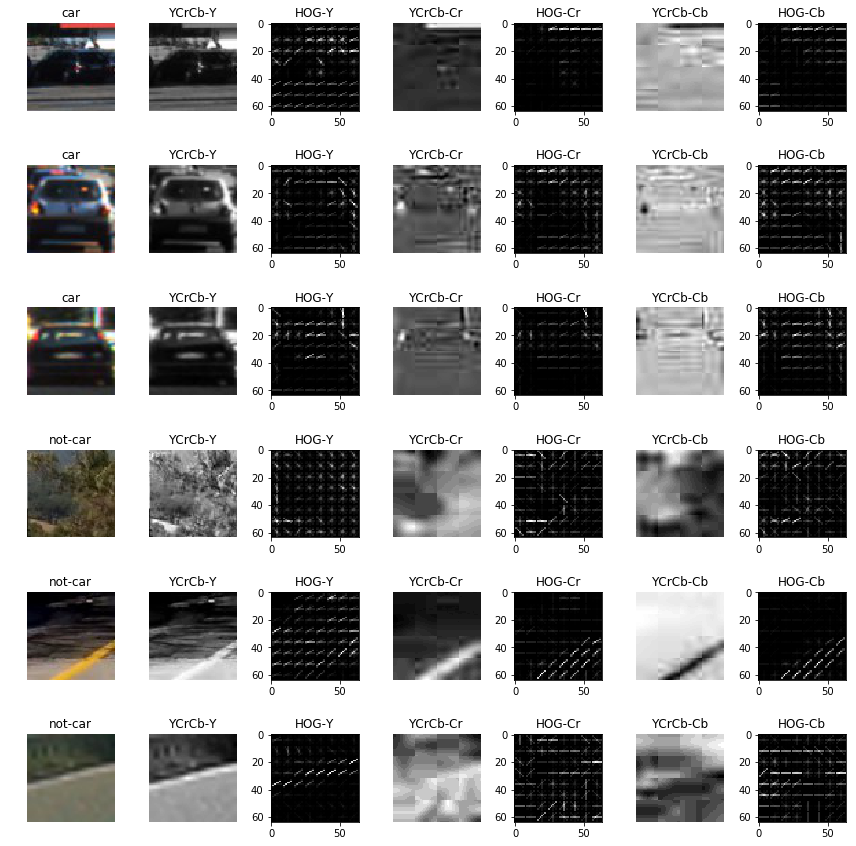

In [7]:
from skimage.feature import hog
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Define HOG parameters
orient = 8
pix_per_cell = 8
cell_per_block = 2

infos =[]
for i in range(3): infos.append((cars_images[i], "car"))
for i in range(3): infos.append((notcars_images[i], "not-car"))
num = len(infos)
fig = plt.figure(figsize=(12,2*num))
for i in range(num):
    image,label = infos[i]
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    f = ['Y','Cr','Cb']
    plt.subplot(num,7,7*i+1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    for j in range(3):
        gray = hsv[:,:,j]
        features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block,\
                                               vis=True, feature_vec=False)
        # Plot a figure with all three bar charts
        plt.subplot(num,7,7*i+2*j+2)
        plt.axis('off')
        plt.imshow(gray, cmap='gray')
        plt.title('YCrCb-{}'.format(f[j]))
        plt.subplot(num,7,7*i+2*j+3)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG-' + format(f[j]))
fig.tight_layout()

### 3. Settled on my final choice of HOG parameters.

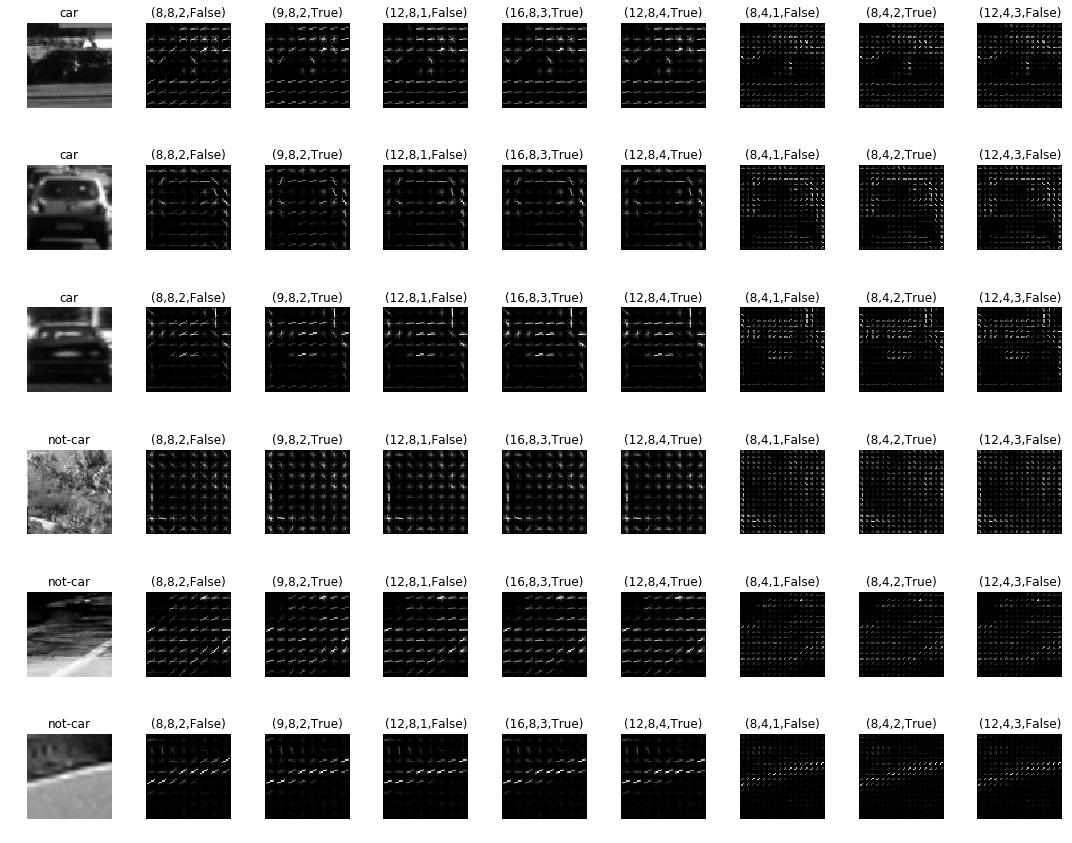

In [8]:
# Define HOG parameters
infos =[]
for i in range(3): infos.append((cars_images[i], "car"))
for i in range(3): infos.append((notcars_images[i], "not-car"))
num = len(infos)
parameters = [(8,8,2,False),(9,8,2,True),(12,8,1,False),(16,8,3,True),(12,8,4,True),
              (8,4,1,False),(8,4,2,True),(12,4,3,False)]
param_num = len(parameters)
fig = plt.figure(figsize=(15,2*num))
for i in range(num):
    image,label = infos[i]
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    gray = hsv[:,:,0]
    plt.subplot(num,(param_num+1),(param_num+1)*i+1)
    plt.axis('off')
    plt.imshow(gray, cmap='gray')
    plt.title(label)
    for j in range(len(parameters)):
        orient,pix_per_cell,cell_per_block,feature_vec = parameters[j]
        features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, \
                                               vis=True, feature_vec=feature_vec)
        plt.subplot(num,(param_num+1),(param_num+1)*i+2+j)
        plt.axis('off')
        plt.imshow(hog_image, cmap='gray')
        plt.title('({},{},{},{})'.format(orient,pix_per_cell,cell_per_block,feature_vec))
fig.tight_layout()

i saw the images above, i choose 
```
orient = 9
pix_per_cell = 8
cell_per_block = 2
feature_vec = True
```

### 4. Trained a classifier using your selected HOG features and color features.

combine the color features and HOG features

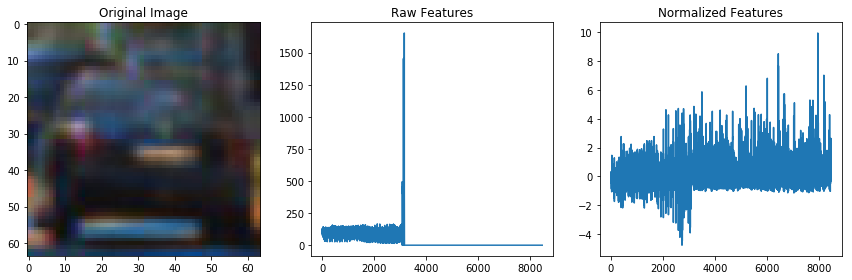

In [20]:
from sklearn.preprocessing import StandardScaler

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_feature(image, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    file_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block, feature_vec=False))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, feature_vec=False)
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return np.concatenate(file_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        feature = extract_feature(image, color_space=color_space, spatial_size=spatial_size,
                                  hist_bins=hist_bins, orient=orient,
                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(feature)
    # Return list of feature vectors
    return features

car_features = extract_features(cars, color_space='YCrCb',spatial_size=(32,32), hist_bins=32,
                                orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
notcar_features = extract_features(notcars, color_space='YCrCb',spatial_size=(32,32), hist_bins=32,
                                orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

I trained a linear SVM using sklearn after shuffle

In [22]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

rand_state = np.random.randint(0, 100)
scaled_X, y = shuffle(scaled_X, y)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a rbf SVC
classifier = SVC(kernel="rbf", C=1.0)
# Check the training time for the SVC
print("begin training with SVM")
t = time.time()
classifier.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(classifier.score(X_test, y_test), 4))

begin training with SVM
(18.18, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9957)


I use grid search to fit the svm parameters to find better paramenters, i found rbf SVC is better than linear SVC, so i use rbf kernel SVC and C=1.0

# Sliding Window Search

### 1. Implemented a sliding window search.

scale=1.5 box_count=350
scale=2 box_count=185
scale=2.5 box_count=116
scale=3 box_count=92


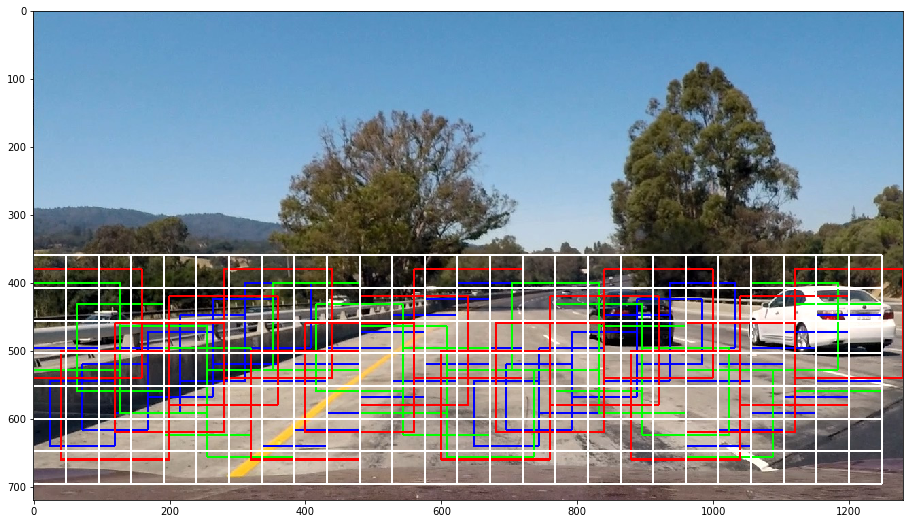

In [34]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

img = mpimg.imread('test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, skip, color):
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    imshape = img_tosearch.shape
    if scale != 1:
        ctrans_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    else:
        ctrans_tosearch = img_tosearch
    
    pix_per_cell = 8

    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell)-1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell)-1 

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    n = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ytop_draw = np.int(ytop*scale)
            xbox_left = np.int(xleft*scale)
            win_draw = np.int(window*scale)
            
            xbox_top = ytop_draw+ystart
            xbox_right = xbox_left+win_draw
            xbox_bottom = xbox_top + win_draw
            if xbox_right > draw_img.shape[1]: continue
            if xbox_bottom > draw_img.shape[0]: continue
            
            if n % skip == 0:
                cv2.rectangle(draw_img,(xbox_left, xbox_top),(xbox_right,xbox_bottom),color,2) 
            n += 1
    print("scale={} box_count={}".format(scale, n))
    return draw_img
    
out_img = img
out_img = find_cars(out_img, 400, 656, 1.5, 13,(0,0,255))
out_img = find_cars(out_img, 400, 656, 2, 11,(0,255,0))
out_img = find_cars(out_img, 380, 680, 2.5, 7,(255,0,0))
out_img = find_cars(out_img, 360, 700, 3, 1,(255,255,255))

plt.figure(figsize=(16,9))
plt.imshow(out_img)

### 2. Show some examples of test images

image 0
image 1
image 2
image 3
image 4
image 5


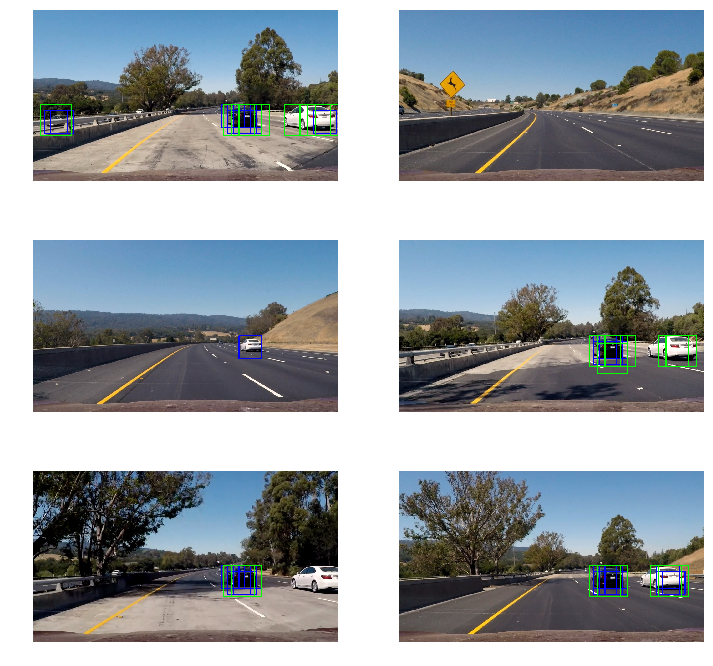

In [39]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def convert_color(img, conv='YCrCb'):
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        return img

# Define a single function that can extract features using hog sub-sampling and make predictions
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                bboxes.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                #cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                #              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)
    return bboxes
    #return draw_img

def process_image(image):
    draw_img = np.copy(image)
    boxes = find_cars(image, 400, 656, 1.5, classifier, X_scaler, 9, 8, 2, (32,32),32)
    for box in boxes:
        cv2.rectangle(draw_img, box[0],box[1], (0, 0, 255), 3)
    boxes = find_cars(image, 400, 656, 2, classifier, X_scaler, 9, 8, 2, (32,32),32)
    for box in boxes:
        cv2.rectangle(draw_img, box[0],box[1], (0, 255, 0), 3)
    return draw_img

image_files = os.listdir("test_images/")
num = len(image_files)
fig, axs = plt.subplots(num//2,2, figsize=(12,2*num))
axs = axs.ravel()
for i in range(num):
    print("image {}".format(i))
    image = mpimg.imread("test_images/" + image_files[i])
    result = process_image(image)
    axs[i].axis('off')
    axs[i].imshow(result)

And then., i use the heatmap, like below

heatmap image 0
heatmap image 1
heatmap image 2
heatmap image 3
heatmap image 4
heatmap image 5


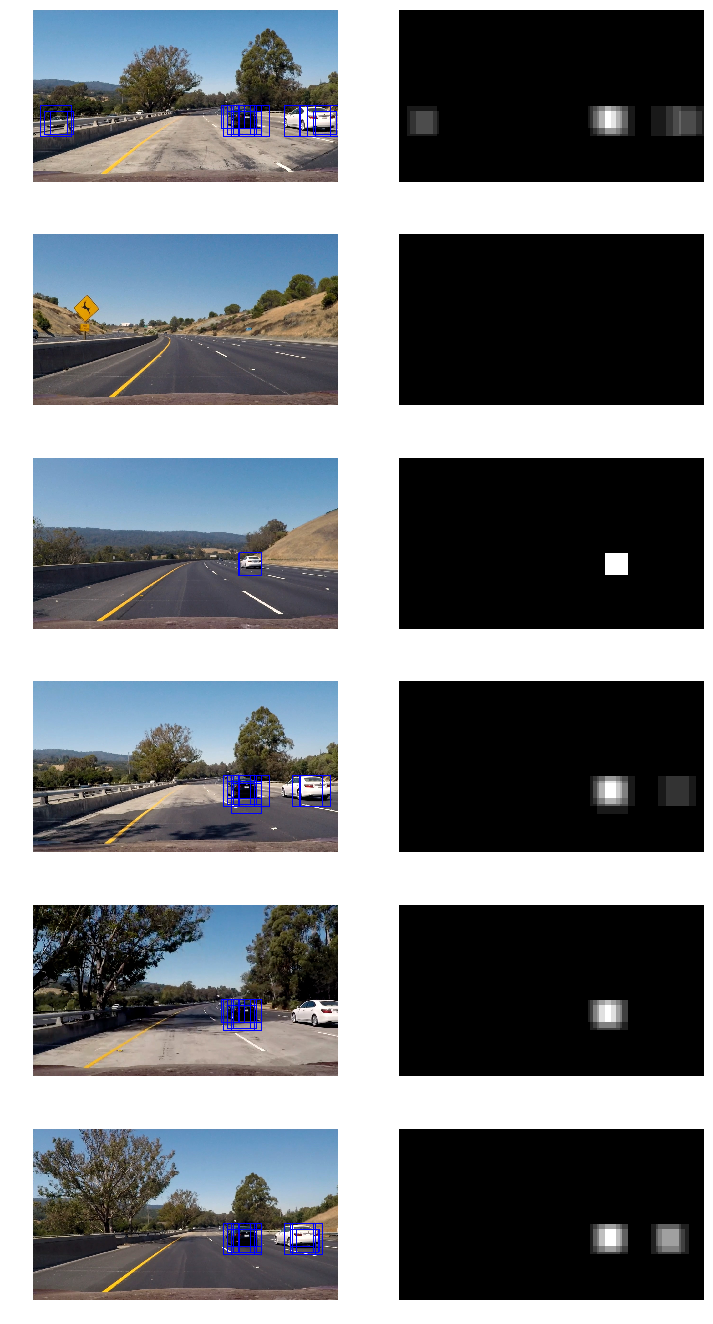

In [47]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

from scipy.ndimage.measurements import label
def process_image(image):
    draw_img = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    boxes = find_cars(image, 400, 656, 1.5, classifier, X_scaler, 9, 8, 2, (32,32),32)
    add_heat(heat, boxes)
    for box in boxes:
        cv2.rectangle(draw_img, box[0],box[1], (0, 0, 255), 3)
    boxes = find_cars(image, 400, 656, 2, classifier, X_scaler, 9, 8, 2, (32,32),32)
    add_heat(heat, boxes)
    for box in boxes:
        cv2.rectangle(draw_img, box[0],box[1], (0, 0, 255), 3)
    heat = apply_threshold(heat, 0)
    heatmap = np.clip(heat, 0, 255)
    return draw_img, heatmap

image_files = os.listdir("test_images/")
num = len(image_files)
fig, axs = plt.subplots(num,2, figsize=(12,4*num))
axs = axs.ravel()
for i in range(num):
    print("heatmap image {}".format(i))
    image = mpimg.imread("test_images/" + image_files[i])
    draw_img, heatmap = process_image(image)
    axs[2*i].axis('off')
    axs[2*i].imshow(draw_img)
    axs[2*i+1].axis('off')
    axs[2*i+1].imshow(heatmap, cmap='gray')

And then., i merge the heatmap, then the final result below

final image 0
final image 1
final image 2
final image 3
final image 4
final image 5


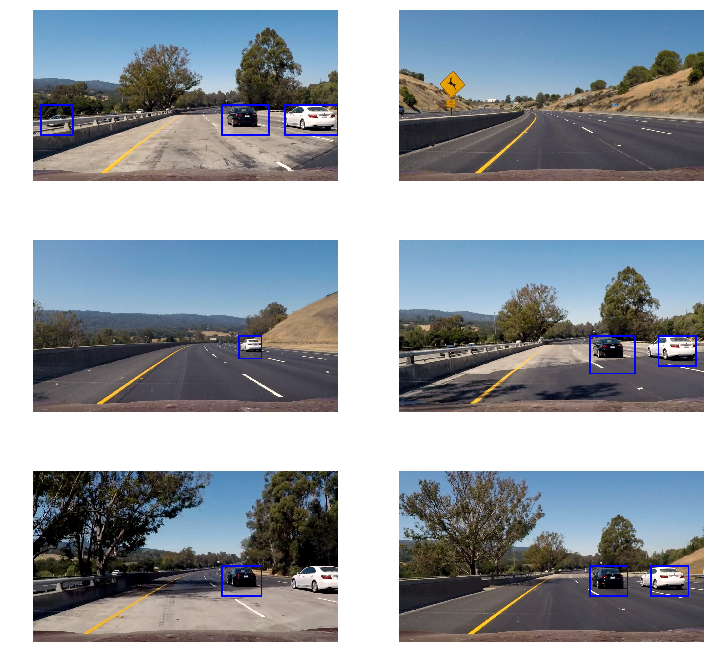

In [49]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def process_image(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    boxes = find_cars(image, 400, 656, 1.5, classifier, X_scaler, 9, 8, 2, (32,32),32)
    add_heat(heat, boxes)
    boxes = find_cars(image, 400, 656, 2, classifier, X_scaler, 9, 8, 2, (32,32),32)
    add_heat(heat, boxes)
    heat = apply_threshold(heat, 0)
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

image_files = os.listdir("test_images/")
num = len(image_files)
fig, axs = plt.subplots(num//2,2, figsize=(12,2*num))
axs = axs.ravel()
for i in range(num):
    print("final image {}".format(i))
    image = mpimg.imread("test_images/" + image_files[i])
    result = process_image(image)
    axs[i].axis('off')
    axs[i].imshow(result)
